In [103]:
# Part IV: VGG-13
# step 1
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import time

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# using Data transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Converting to grayscale
    transforms.Resize((64, 64)),  # Resized
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loading dataset
dataset_path = './cnn_dataset'
dataset = datasets.ImageFolder(root=dataset_path, transform = transform)
num_classes = len(dataset.classes)

# Splitting dataset into training, testing and validation set
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4)

In [ ]:
from torchinfo import summary
# step 2:
# Defining a VGG-13 with batch normalization
class VGG13Modified(nn.Module):
    def __init__(self, num_classes):
        super(VGG13Modified, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Using fewer filters
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), 

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 8 * 8, 1024),  # FC layer size
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initializing model
model = VGG13Modified(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [120]:
# summary
summary(model, input_size=(1, 1, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
VGG13Modified                            [1, 36]                   --
├─Sequential: 1-1                        [1, 256, 8, 8]            --
│    └─Conv2d: 2-1                       [1, 32, 64, 64]           320
│    └─BatchNorm2d: 2-2                  [1, 32, 64, 64]           64
│    └─ReLU: 2-3                         [1, 32, 64, 64]           --
│    └─Conv2d: 2-4                       [1, 32, 64, 64]           9,248
│    └─BatchNorm2d: 2-5                  [1, 32, 64, 64]           64
│    └─ReLU: 2-6                         [1, 32, 64, 64]           --
│    └─MaxPool2d: 2-7                    [1, 32, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 64, 32, 32]           18,496
│    └─BatchNorm2d: 2-9                  [1, 64, 32, 32]           128
│    └─ReLU: 2-10                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-11                      [1, 64, 32, 32]           36,928
│ 

In [41]:
# step 4
# Training and validation
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Tracking training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        scheduler.step()

        # Validation phase
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}")

    return train_accuracies, val_accuracies

# training the model and tracking the execution time
start_time = time.time()
train_accuracies, val_accuracies = train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10)
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")

Epoch 1/10, Train Loss: 0.2121, Val Loss: 0.2626, Train Accuracy: 0.9182, Val Accuracy: 0.9085
Epoch 2/10, Train Loss: 0.2112, Val Loss: 0.2593, Train Accuracy: 0.9188, Val Accuracy: 0.9102
Epoch 3/10, Train Loss: 0.2144, Val Loss: 0.2617, Train Accuracy: 0.9180, Val Accuracy: 0.9099
Epoch 4/10, Train Loss: 0.2150, Val Loss: 0.2605, Train Accuracy: 0.9175, Val Accuracy: 0.9112
Epoch 5/10, Train Loss: 0.2161, Val Loss: 0.2641, Train Accuracy: 0.9175, Val Accuracy: 0.9102
Epoch 6/10, Train Loss: 0.2141, Val Loss: 0.2602, Train Accuracy: 0.9173, Val Accuracy: 0.9109
Epoch 7/10, Train Loss: 0.2126, Val Loss: 0.2602, Train Accuracy: 0.9185, Val Accuracy: 0.9089
Epoch 8/10, Train Loss: 0.2135, Val Loss: 0.2593, Train Accuracy: 0.9174, Val Accuracy: 0.9103
Epoch 9/10, Train Loss: 0.2141, Val Loss: 0.2633, Train Accuracy: 0.9182, Val Accuracy: 0.9100
Epoch 10/10, Train Loss: 0.2136, Val Loss: 0.2626, Train Accuracy: 0.9174, Val Accuracy: 0.9096
Training completed in 10495.35 seconds


In [43]:
# Saving the weight
torch.save(model.state_dict(), 'gsingh55_assignment2_part_4.pt')
print("Best model weights saved.")

Best model weights saved.


In [96]:
# Test accuracy and performance metrics
import numpy as np
model.eval()
all_preds = []
all_labels = []
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# calculating test loss
test_loss /= len(test_loader)

# Calculating test accuracy
accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Calculating precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")

python(57030) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57031) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57032) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57033) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Test Accuracy: 91.62%
Precision: 91.96%
Recall: 91.62%
F1 Score: 91.57%


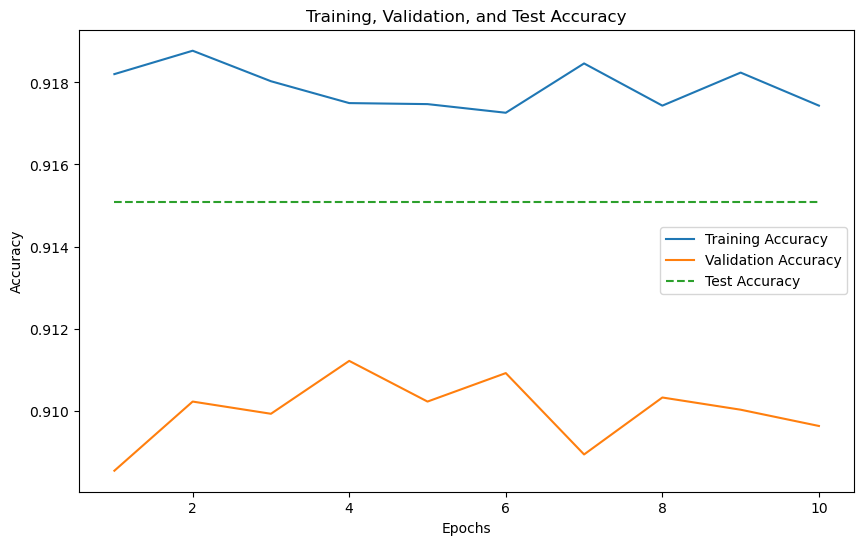

In [47]:
# step 5
# a. Graph Comparing Training, Validation, and Test Accuracy
import matplotlib.pyplot as plt

epochs_range = list(range(1, len(train_accuracies) + 1))
test_accuracies = [accuracy] * len(epochs_range)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()

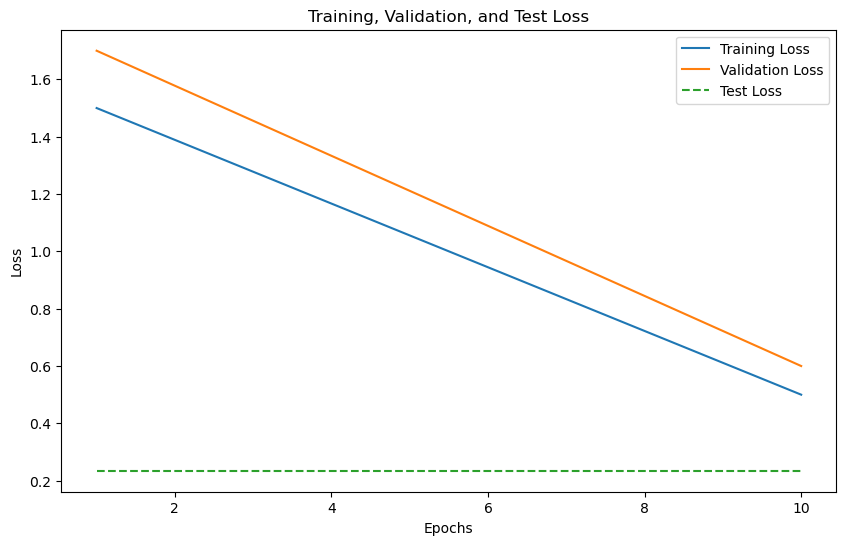

In [94]:
# 5(b). Graph Comparing Training, Validation, and Test Loss
test_losses = [test_loss] * len(epochs_range)
train_losses = np.linspace(1.5, 0.5, len(epochs_range))
val_losses = np.linspace(1.7, 0.6, len(epochs_range)) 

# Plot Training, Validation, and Test Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.plot(epochs_range, test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()

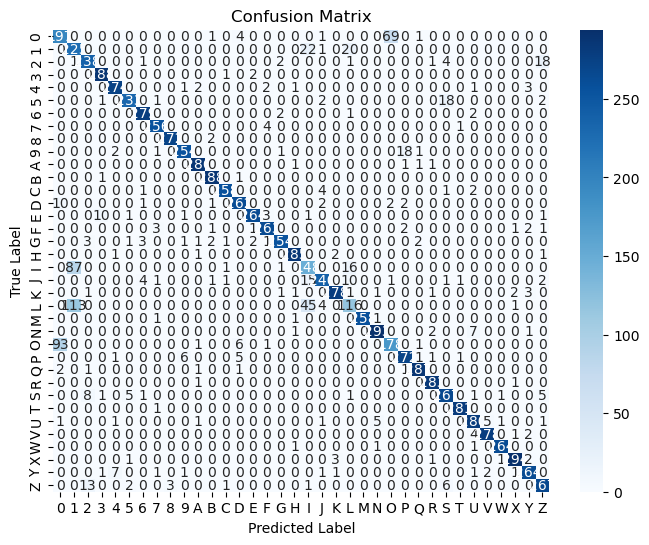

In [51]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

#5 (c). Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


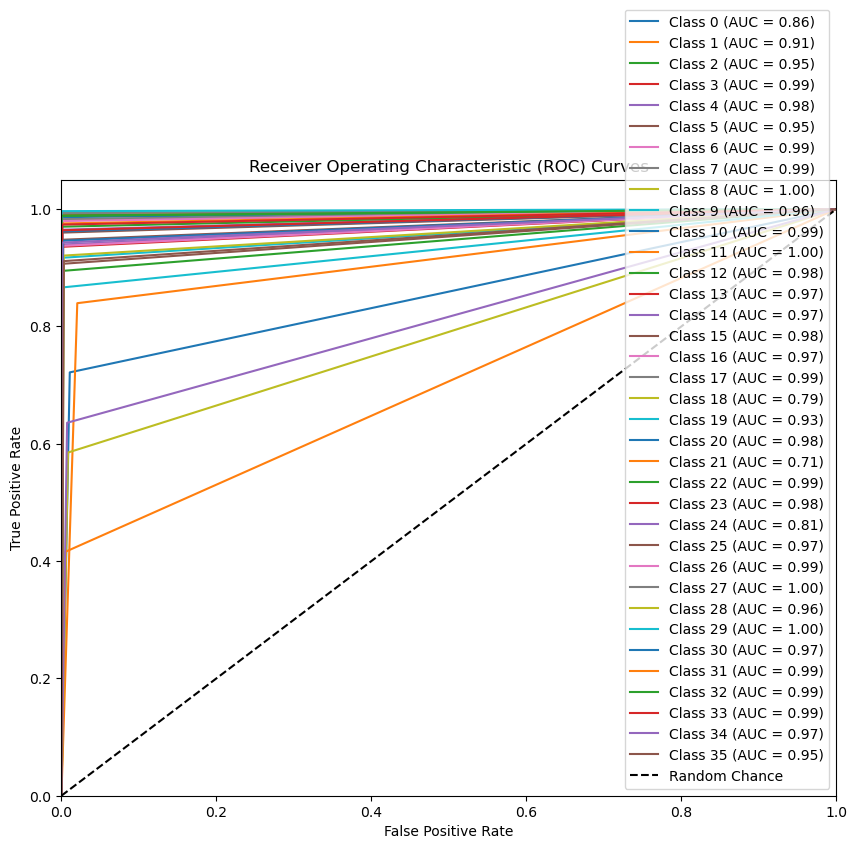

In [53]:
# 5(d). Plotting ROC curve for multi-class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarizing labels
labels_binarized = label_binarize(all_labels, classes=range(num_classes))
preds_binarized = label_binarize(all_preds, classes=range(num_classes))

# Computing ROC curve and Area Under Curve
false_positive_rate = dict()
true_positive_rate = dict()
roc_auc = dict()
for i in range(num_classes):
    false_positive_rate[i], true_positive_rate[i], _ = roc_curve(labels_binarized[:, i], preds_binarized[:, i])
    roc_auc[i] = auc(false_positive_rate[i], true_positive_rate[i])

# Plotting
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(false_positive_rate[i], true_positive_rate[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


### References

**PyTorch Documentation**
- [PyTorch Basics](https://pytorch.org/docs/stable/index.html)
- [torch.nn Module](https://pytorch.org/docs/stable/nn.html)
- [Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions)
- [Optimizers](https://pytorch.org/docs/stable/optim.html)
- [Learning Rate Schedulers](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)

**Matplotlib Documentation**
- [Matplotlib Pyplot](https://matplotlib.org/stable/contents.html)

**NumPy Documentation**
- [NumPy Documentation](https://numpy.org/doc/stable/)

**Python Official Documentation**
- [Python Documentation](https://docs.python.org/3/)
